In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, load_model
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dropout, Dense, BatchNormalization
from sklearn.preprocessing import OneHotEncoder

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_val = x_train[40000:]
y_val = y_train[40000:]
x_train = x_train[:40000]
y_train = y_train[:40000]

169017344/169001437 [==============================] - 6s 0us/step


In [ ]:
x_train = tf.keras.applications.efficientnet.preprocess_input(x_train)
x_val = tf.keras.applications.efficientnet.preprocess_input(x_val)
x_test = tf.keras.applications.efficientnet.preprocess_input(x_test)

In [ ]:
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train)
y_val = onehot.transform(y_val)
y_test = onehot.transform(y_test)

In [ ]:
# initial hyper-parameter
batch_size = 64
num_classes = 100
epochs = 15

In [ ]:
efficientNet = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=num_classes)
efficientNet.summary()

31801344/31790344 [==============================] - 0s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Zero

In [ ]:
model = Sequential([
    UpSampling2D(size=(7,7)),
    efficientNet,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')                   
])

In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer= optimizer,
              metrics=['accuracy'])


In [ ]:
# link folder Save model to drive
!ln -s /content/drive/'My Drive'/CW1/Save_model /content/

In [ ]:
save_dir = 'Save_model/'
model_name = 'model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [ ]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

#checkpoint
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [ ]:
# Generate augmented images
datagen = ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)
datagen.fit(x_train)

In [ ]:
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              epochs=epochs,
              verbose = 1,
              callbacks = [early_stop, checkpoint]
             )

Epoch 1/15
625/625 [==============================] - ETA: 0s - loss: 2.7366 - accuracy: 0.3735
Epoch 00001: val_accuracy improved from -inf to 0.71750, saving model to Save_model/model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


625/625 [==============================] - 1102s 2s/step - loss: 2.7366 - accuracy: 0.3735 - val_loss: 1.0061 - val_accuracy: 0.7175
Epoch 2/15
625/625 [==============================] - ETA: 0s - loss: 1.0133 - accuracy: 0.7133
Epoch 00002: val_accuracy improved from 0.71750 to 0.79030, saving model to Save_model/model.h5
625/625 [==============================] - 1072s 2s/step - loss: 1.0133 - accuracy: 0.7133 - val_loss: 0.6982 - val_accuracy: 0.7903
Epoch 3/15
625/625 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.8016
Epoch 00003: val_accuracy improved from 0.79030 to 0.81850, saving model to Save_model/model.h5
625/625 [==============================] - 1060s 2s/step - loss: 0.6709 - accuracy: 0.8016 - val_loss: 0.6177 - val_accuracy: 0.8185
Epoch 4/15
625/625 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.8562
Epoch 00004: val_accuracy improved from 0.81850 to 0.82940, saving model to Save_model/model.h5
625/625 [================

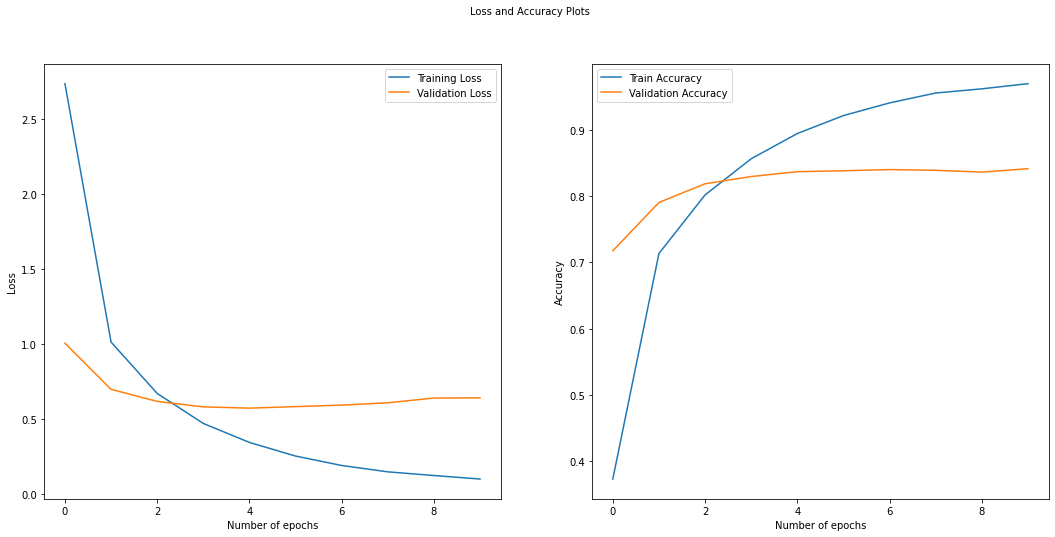

In [ ]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=10)

plt.subplot(1,2,1)
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)

plt.subplot(1,2,2)
plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.show()

In [ ]:
loss_test, accuracy_test = model.evaluate(x_test,y_test, verbose = 1)
print('Test Accuracy: ', round((accuracy_test * 100), 2), "%")

313/313 [==============================] - 68s 214ms/step - loss: 0.5576 - accuracy: 0.8372
Test Accuracy:  83.72 %


In [ ]:
model = load_model("Save_model/model.h5")
score = model.evaluate(x_test, y_test)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

313/313 [==============================] - 70s 215ms/step - loss: 0.9170 - accuracy: 0.7523
Test loss: 0.9170
Test accuracy: 0.7523
